# Imports

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from utils import conexion_db
import seaborn as sns
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.cm as cm

# 1. Usuarios que m√°s cl√°usulas HAN HECHO (robado)

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1669652385.py:11: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



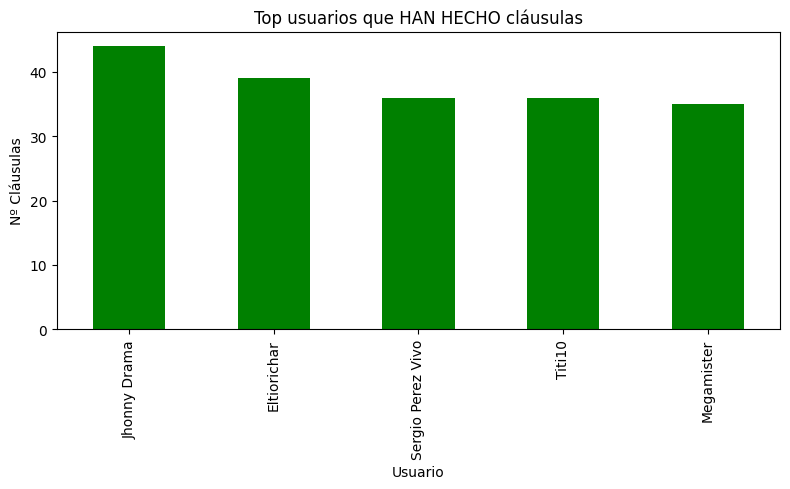

In [49]:
with conexion_db() as conn:
    query_realizadas = """
        SELECT usuario_destino AS usuario, COUNT(*) AS clausulas_realizadas
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cl√°usula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY usuario_destino
        ORDER BY clausulas_realizadas DESC
        LIMIT 5;
    """
    df_realizadas = pd.read_sql(query_realizadas, conn)

fig, ax = plt.subplots(figsize=(8, 5))
df_realizadas.plot(kind='bar', x='usuario', y='clausulas_realizadas', legend=False, ax=ax, color='green')
ax.set_title('Top usuarios que HAN HECHO cl√°usulas')
ax.set_xlabel('Usuario')
ax.set_ylabel('N¬∫ Cl√°usulas')
plt.tight_layout()
plt.show()

 # 2. Usuarios que m√°s cl√°usulas HAN SUFRIDO

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\2937050547.py:11: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



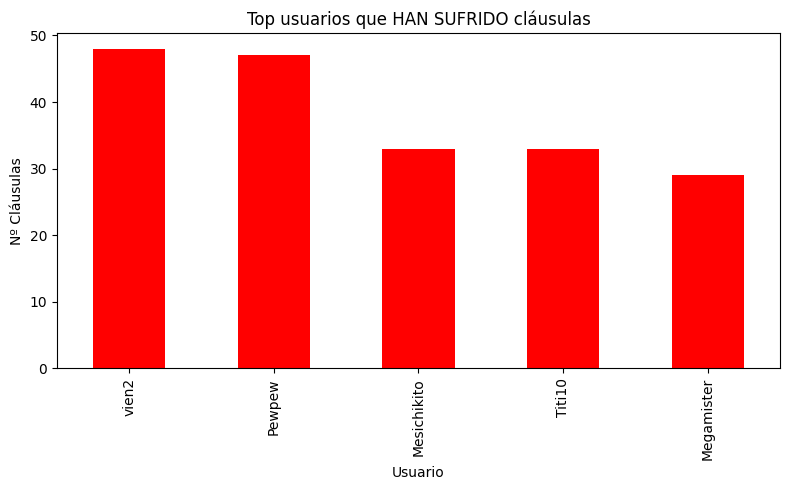

In [50]:
with conexion_db() as conn:
    query_sufridas = """
        SELECT usuario_origen AS usuario, COUNT(*) AS clausulas_sufridas
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cl√°usula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY usuario_origen
        ORDER BY clausulas_sufridas DESC
        LIMIT 5;
    """
    df_sufridas = pd.read_sql(query_sufridas, conn)

fig, ax = plt.subplots(figsize=(8, 5))
df_sufridas.plot(kind='bar', x='usuario', y='clausulas_sufridas', legend=False, ax=ax, color='red')
ax.set_title('Top usuarios que HAN SUFRIDO cl√°usulas')
ax.set_xlabel('Usuario')
ax.set_ylabel('N¬∫ Cl√°usulas')
plt.tight_layout()
plt.show()

# 3. Tops robos entre usuarios

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1600032388.py:14: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



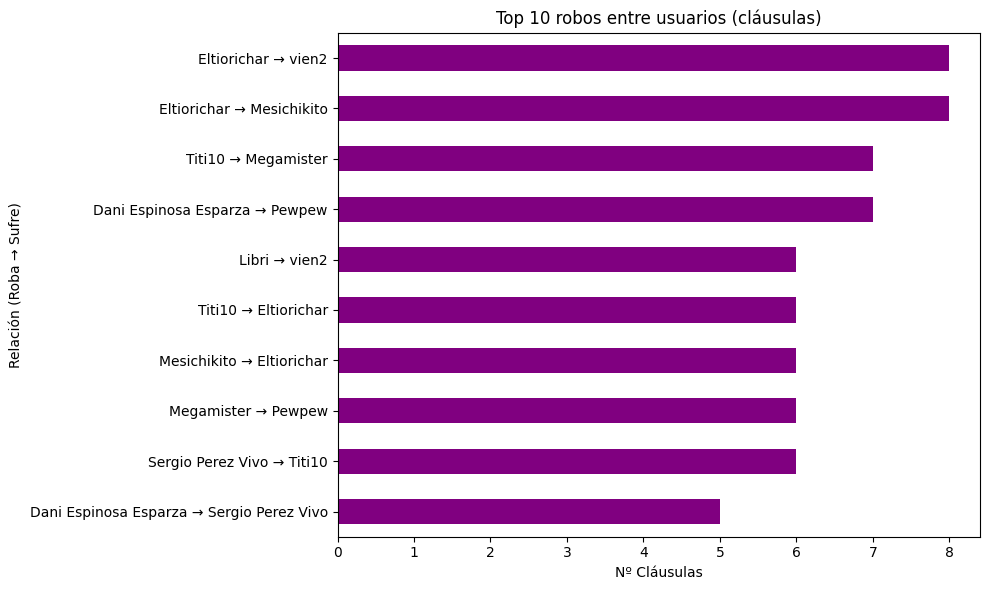

In [51]:
with conexion_db() as conn:
    query_robos = """
        SELECT 
            usuario_destino AS quien_roba,
            usuario_origen AS quien_sufre,
            COUNT(*) AS clausulas
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cl√°usula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY usuario_destino, usuario_origen
        ORDER BY clausulas DESC
        LIMIT 10;
    """
    df_robos = pd.read_sql(query_robos, conn)

# Crear una nueva columna para mostrar la relaci√≥n
df_robos['relacion'] = df_robos['quien_roba'] + ' ‚Üí ' + df_robos['quien_sufre']

# Gr√°fico
fig, ax = plt.subplots(figsize=(10, 6))
df_robos.plot(kind='barh', x='relacion', y='clausulas', ax=ax, color='purple', legend=False)
ax.set_title('Top 10 robos entre usuarios (cl√°usulas)')
ax.set_xlabel('N¬∫ Cl√°usulas')
ax.set_ylabel('Relaci√≥n (Roba ‚Üí Sufre)')
plt.gca().invert_yaxis()  # Para que el m√°s alto aparezca arriba
plt.tight_layout()
plt.show()


# 4. HeatMap Robos entre usuarios

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\2185274892.py:13: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



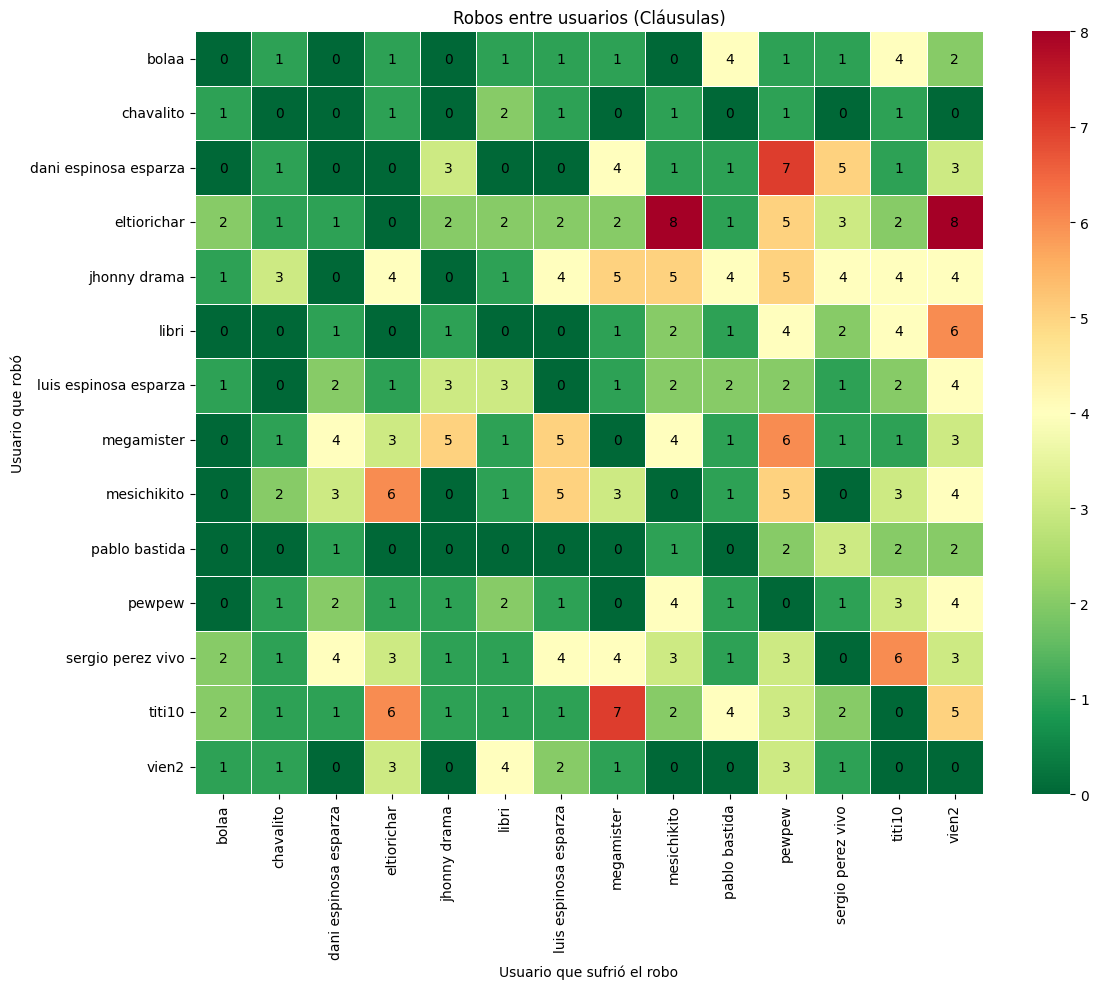

In [52]:
# 1. Cargar datos brutos
with conexion_db() as conn:
    query = """
        SELECT 
            usuario_destino AS quien_roba,
            usuario_origen AS quien_sufre,
            COUNT(*) AS clausulas
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cl√°usula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY usuario_destino, usuario_origen;
    """
    df_raw = pd.read_sql(query, conn)

# 2. Limpiar antes de agrupar
df_raw['quien_roba'] = df_raw['quien_roba'].str.strip().str.lower()
df_raw['quien_sufre'] = df_raw['quien_sufre'].str.strip().str.lower()

# 3. Re-agrupar (por si los nombres duplicados generaron filas separadas)
df = df_raw.groupby(['quien_roba', 'quien_sufre'], as_index=False).sum()

# 4. Crear la tabla pivote
pivot = df.pivot(index='quien_roba', columns='quien_sufre', values='clausulas').fillna(0)

# 5. Visualizar
plt.figure(figsize=(12, 10))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".0f",
    cmap='RdYlGn_r',
    linewidths=0.5,
    cbar=True,
    annot_kws={"size": 10, "color": "black"}
)
plt.title("Robos entre usuarios (Cl√°usulas)")
plt.xlabel("Usuario que sufri√≥ el robo")
plt.ylabel("Usuario que rob√≥")
plt.tight_layout()
plt.show()


# 5. Jugador con m√°s clausulazos

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1830698233.py:14: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



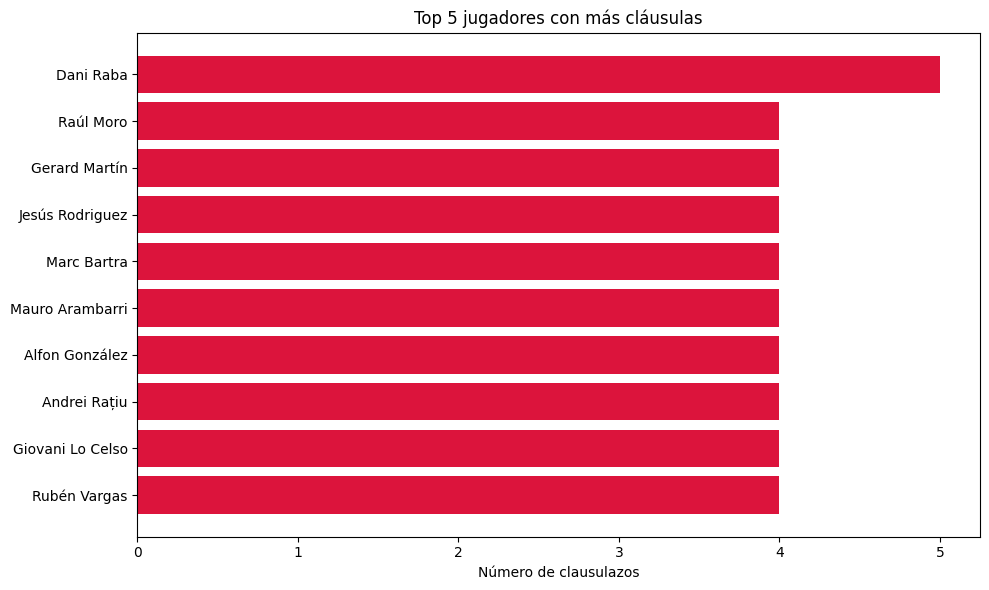

In [53]:
with conexion_db() as conn:
    query = """
        SELECT 
            nombre,
            apellido,
            COUNT(*) AS clausulazos
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cl√°usula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY nombre, apellido
        ORDER BY clausulazos DESC
        LIMIT 10;
    """
    df_raw = pd.read_sql(query, conn)

# Gr√°fico
plt.figure(figsize=(10, 6))
plt.barh(
    df_raw['nombre'] + ' ' + df_raw['apellido'],
    df_raw['clausulazos'],
    color='crimson'
)
plt.xlabel('N√∫mero de clausulazos')
plt.title('Top 5 jugadores con m√°s cl√°usulas')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# 6. Jugador con m√°s traspasos

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\549213003.py:14: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



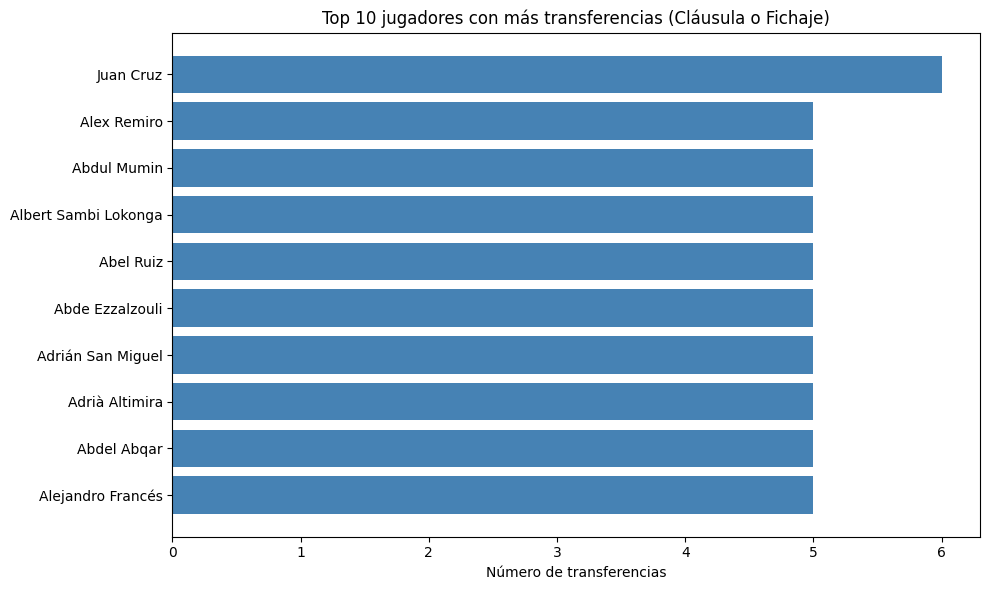

In [54]:
with conexion_db() as conn:
    query = """
        SELECT 
            nombre,
            apellido,
            COUNT(*) AS total_transferencias
        FROM dbo.v_transferencias
        WHERE tipo_operacion IN ('Cl√°usula', 'Fichaje')
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY nombre, apellido
        ORDER BY total_transferencias DESC
        LIMIT 10;
    """
    df_transferencias = pd.read_sql(query, conn)

# Gr√°fico
plt.figure(figsize=(10, 6))
plt.barh(
    df_transferencias['nombre'] + ' ' + df_transferencias['apellido'],
    df_transferencias['total_transferencias'],
    color='steelblue'
)
plt.xlabel('N√∫mero de transferencias')
plt.title('Top 10 jugadores con m√°s transferencias (Cl√°usula o Fichaje)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 7. Jugador que m√°s dinero ha movido (top 3)

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\3725145374.py:14: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



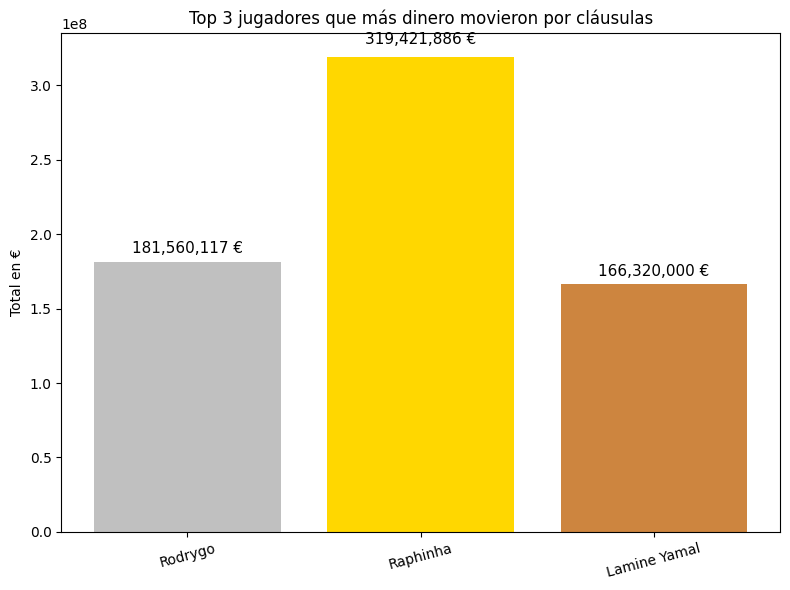

In [55]:
with conexion_db() as conn:
    query = """
        SELECT 
            nombre,
            apellido,
            SUM(precio) AS total_dinero
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cl√°usula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY nombre, apellido
        ORDER BY total_dinero DESC
        LIMIT 3;
    """
    df_podio = pd.read_sql(query, conn)

# Crear columna con nombre completo, asegurando texto
df_podio['jugador'] = (df_podio['nombre'].fillna('') + ' ' + df_podio['apellido'].fillna('')).str.strip()

# Orden para estilo podio
df_podio = df_podio.sort_values('total_dinero', ascending=False).reset_index(drop=True)
df_podio = df_podio.loc[[1, 0, 2]] if len(df_podio) == 3 else df_podio  # solo si hay 3 jugadores

# Convertir a arrays
jugadores = df_podio['jugador'].astype(str).values
valores = df_podio['total_dinero'].astype(float).values

# Gr√°fico estilo podio
colors = ['silver', 'gold', 'peru']  # ü•àü•áü•â
plt.figure(figsize=(8, 6))
bars = plt.bar(jugadores, valores, color=colors[:len(jugadores)])

# A√±adir valores encima
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + yval*0.02, f"{int(yval):,} ‚Ç¨", 
             ha='center', va='bottom', fontsize=11)

plt.title("Top 3 jugadores que m√°s dinero movieron por cl√°usulas")
plt.ylabel("Total en ‚Ç¨")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 7. Jugador que m√°s dinero ha movido (top 5)

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\2182357760.py:14: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



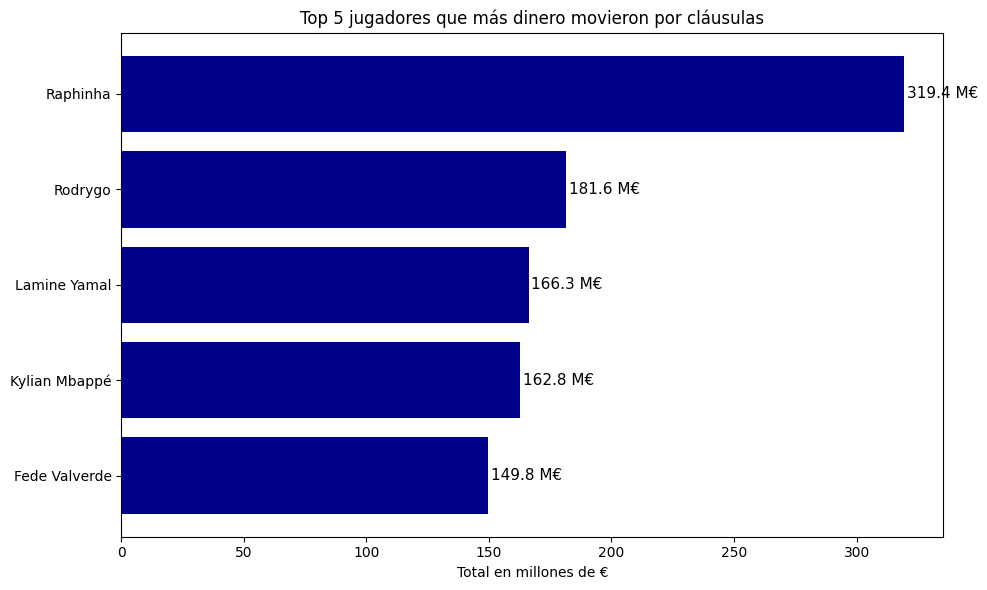

In [56]:
with conexion_db() as conn:
    query = """
        SELECT 
            nombre,
            apellido,
            SUM(precio) AS total_dinero
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cl√°usula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
        GROUP BY nombre, apellido
        ORDER BY total_dinero DESC
        LIMIT 5;
    """
    df_top5 = pd.read_sql(query, conn)

# Formatear datos
df_top5['jugador'] = (df_top5['nombre'].fillna('') + ' ' + df_top5['apellido'].fillna('')).str.strip()
df_top5['millones'] = (df_top5['total_dinero'] / 1_000_000).round(1)

# Gr√°fico horizontal
plt.figure(figsize=(10, 6))
bars = plt.barh(df_top5['jugador'], df_top5['millones'], color='darkblue')

# Etiquetas a la derecha de las barras
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f"{width:.1f} M‚Ç¨", va='center', fontsize=11)

plt.xlabel("Total en millones de ‚Ç¨")
plt.title("Top 5 jugadores que m√°s dinero movieron por cl√°usulas")
plt.gca().invert_yaxis()  # Poner al m√°s caro arriba
plt.tight_layout()
plt.show()


# 8. Jugadores con mayor beneficio neto

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1313728641.py:19: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1313728641.py:27: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1313728641.py:36: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1313728641.py:44: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 

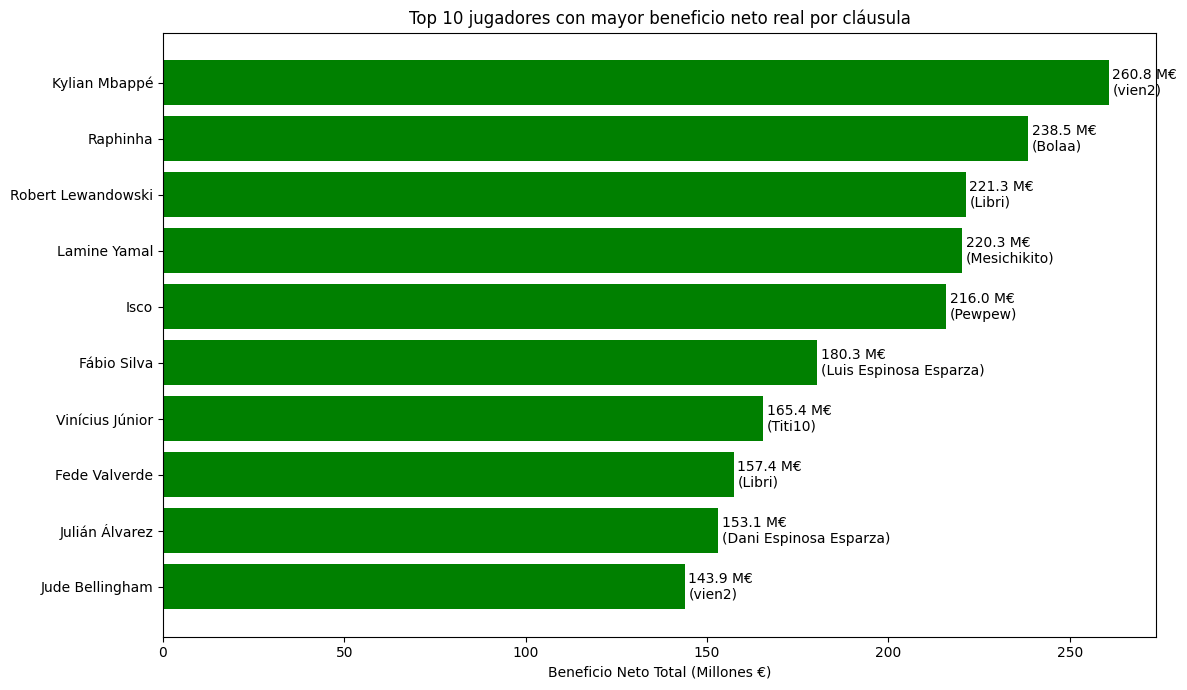

In [86]:
# Bonificaciones (en ‚Ç¨)
BONUS_POR_PUNTO = 50000
BONUS_POR_GOL = 1000000
BONUS_POR_JORNADA = 500000
BONUS_ONCE_IDEAL = 500000
BONUS_CLASIFICACION = {
    1: 500000, 2: 600000, 3: 700000, 4: 800000, 5: 900000,
    6: 1000000, 7: 1100000, 8: 1200000, 9: 1300000, 10: 1400000,
    11: 1500000, 12: 1600000, 13: 1700000
}

# 1. Cargar jugadores fichados por cl√°usula
with conexion_db() as conn:
    jugadores_sql = """
        SELECT id_jugador, nombre, apellido, propietario, fecha, precio, clausula
        FROM dbo.v_datos_jugador
        WHERE clausula > precio AND fecha BETWEEN '2024-08-15' AND '2025-06-30'
    """
    df_jugadores = pd.read_sql(jugadores_sql, conn)

    # 2. Datos de rendimiento por jornada
    jornadas_sql = """
        SELECT id_jugador, jornada, puntuacion, eventos
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25'
    """
    df_jornadas = pd.read_sql(jornadas_sql, conn)
    df_jornadas['goles'] = df_jornadas['eventos'].fillna('').str.count(r'\bgol\b')

    # 3. Once ideal
    once_ideal_sql = """
        SELECT id_jugador, jornada
        FROM dbo.v_best_xi_jornadas
        WHERE temporada = '24/25'
    """
    df_once = pd.read_sql(once_ideal_sql, conn)

    # 4. Clasificaci√≥n por jornada
    clasif_sql = """
        SELECT jornada, usuario, posicion
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
    """
    df_clasif = pd.read_sql(clasif_sql, conn)

# 5. Calcular bonificaciones por jugador
resultados = []


for _, row in df_jugadores.iterrows():
    id_jugador = row['id_jugador']
    usuario = row['propietario']
    fecha_fichaje = row['fecha']
    precio = row['precio']
    clausula = row['clausula']
    nombre = (str(row['nombre']) if row['nombre'] else '').strip()
    apellido = (str(row['apellido']) if row['apellido'] else '').strip()
    nombre_completo = f"{nombre} {apellido}".strip()

    # Jornadas del jugador desde su fichaje
    jugador_jornadas = df_jornadas[df_jornadas['id_jugador'] == id_jugador]
    jornadas_disputadas = jugador_jornadas['jornada'].nunique()
    puntos = jugador_jornadas['puntuacion'].sum()
    goles = jugador_jornadas['goles'].sum()

    # Once ideal
    apariciones_once = df_once[df_once['id_jugador'] == id_jugador]['jornada'].nunique()

    # Bonificaciones por clasificaci√≥n
    clasif_usuario = df_clasif[df_clasif['usuario'] == usuario]
    #bonus_clasificacion = sum(BONUS_CLASIFICACION.get(pos, 0) for pos in clasif_usuario['posicion'])

    # Calcular bonificaci√≥n total
    bonificacion_total = (
        puntos * BONUS_POR_PUNTO +
        goles * BONUS_POR_GOL +
        jornadas_disputadas * BONUS_POR_JORNADA +
        apariciones_once * BONUS_ONCE_IDEAL 
        #+
        #bonus_clasificacion
    )

    beneficio_neto_total = clausula - precio + bonificacion_total

    resultados.append({
        'jugador': nombre_completo,
        'usuario': usuario,
        'beneficio_neto_total': beneficio_neto_total
    })

# 6. Crear DataFrame final y mostrar top 10
df_resultados = pd.DataFrame(resultados)

top10 = df_resultados.sort_values(by='beneficio_neto_total', ascending=False).head(10)

# 7. Graficar
plt.figure(figsize=(12, 7))
bars = plt.barh(top10['jugador'], top10['beneficio_neto_total'] / 1_000_000, color='green')

for i, bar in enumerate(bars):
    beneficio = top10.iloc[i]['beneficio_neto_total'] / 1_000_000
    usuario = top10.iloc[i]['usuario']
    plt.text(beneficio + 1, bar.get_y() + bar.get_height()/2,
             f"{beneficio:.1f} M‚Ç¨\n({usuario})", va='center', fontsize=10)

plt.xlabel("Beneficio Neto Total (Millones ‚Ç¨)")
plt.title("Top 10 jugadores con mayor beneficio neto real por cl√°usula")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# 9. Jugadores con menor beneficio neto

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1199394987.py:19: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1199394987.py:29: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1199394987.py:40: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1199394987.py:50: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 

N√∫mero de jugadores fichados por cl√°usula: 218


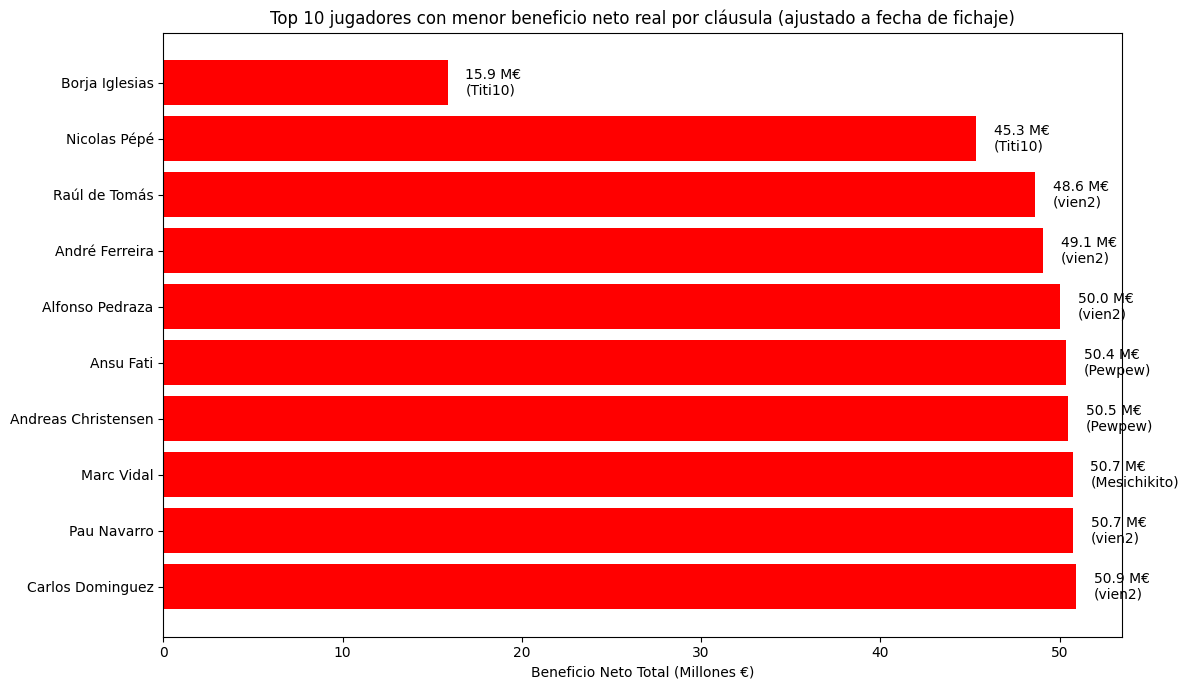

In [58]:
# Bonificaciones (en ‚Ç¨)
BONUS_POR_PUNTO = 50000
BONUS_POR_GOL = 1000000
BONUS_POR_JORNADA = 500000
BONUS_ONCE_IDEAL = 500000
BONUS_CLASIFICACION = {
    1: 500000, 2: 600000, 3: 700000, 4: 800000, 5: 900000,
    6: 1000000, 7: 1100000, 8: 1200000, 9: 1300000, 10: 1400000,
    11: 1500000, 12: 1600000, 13: 1700000
}

with conexion_db() as conn:
    # 1. Jugadores fichados por cl√°usula
    jugadores_sql = """
        SELECT id_jugador, nombre, apellido, propietario, fecha, precio, clausula
        FROM dbo.v_datos_jugador
        WHERE clausula > precio AND fecha BETWEEN '2024-08-15' AND '2025-06-30'
    """
    df_jugadores = pd.read_sql(jugadores_sql, conn)
    df_jugadores['fecha'] = pd.to_datetime(df_jugadores['fecha'])


    # 2. Datos de jornada + fechas
    jornadas_sql = """
        SELECT id_jugador, jornada, puntuacion, eventos, f_carga::date as fecha_jornada
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25'
    """
    df_jornadas = pd.read_sql(jornadas_sql, conn)
    df_jornadas['goles'] = df_jornadas['eventos'].fillna('').str.count(r'\bgol\b')
    df_jornadas['fecha_jornada'] = pd.to_datetime(df_jornadas['fecha_jornada'])


    # 3. Once ideal
    once_ideal_sql = """
        SELECT id_jugador, jornada
        FROM dbo.v_best_xi_jornadas
        WHERE temporada = '24/25'
    """
    df_once = pd.read_sql(once_ideal_sql, conn)
    df_once['jornada'] = df_once['jornada'].str.extract(r'(\d+)').astype(int)


    # 4. Clasificaci√≥n por jornada
    clasif_sql = """
        SELECT jornada, usuario, posicion
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
    """
    df_clasif = pd.read_sql(clasif_sql, conn)
    df_clasif['jornada'] = df_clasif['jornada'].astype(int)


# Mapeo jornada ‚Üî fecha m√≠nima para filtrar correctamente
jornada_fecha_map = (
    df_jornadas[['jornada', 'fecha_jornada']]
    .dropna()
    .groupby('jornada')['fecha_jornada']
    .min()
    .to_dict()
)

# 5. Calcular bonificaciones reales por jugador
resultados = []
print(f"N√∫mero de jugadores fichados por cl√°usula: {len(df_jugadores)}")

for _, row in df_jugadores.iterrows():
    id_jugador = row['id_jugador']
    usuario = row['propietario']
    fecha_fichaje = row['fecha']
    precio = row['precio']
    clausula = row['clausula']
    nombre = (str(row['nombre']) if row['nombre'] else '').strip()
    apellido = (str(row['apellido']) if row['apellido'] else '').strip()
    nombre_completo = f"{nombre} {apellido}".strip()

    # Determinar desde qu√© jornada contar (la primera con fecha igual o posterior al fichaje)
    jornada_fichaje = min(
        (j for j, f in jornada_fecha_map.items() if f >= fecha_fichaje),
        default=None
    )
    if jornada_fichaje is None:
        continue  # No hay jornadas posteriores al fichaje

    # --- Jornadas jugadas por el jugador desde el fichaje ---
    jugador_jornadas = df_jornadas[
        (df_jornadas['id_jugador'] == id_jugador) &
        (df_jornadas['jornada'] >= jornada_fichaje)
    ]
    jornadas_disputadas = jugador_jornadas['jornada'].nunique()
    puntos = jugador_jornadas['puntuacion'].sum()
    goles = jugador_jornadas['goles'].sum()

    # --- Apariciones en once ideal desde esa jornada ---
    apariciones_once = df_once[
        (df_once['id_jugador'] == id_jugador) &
        (df_once['jornada'] >= jornada_fichaje)
    ]['jornada'].nunique()

    # --- Clasificaciones del usuario desde esa jornada ---
    clasif_usuario = df_clasif[
        (df_clasif['usuario'] == usuario) &
        (df_clasif['jornada'] >= jornada_fichaje)
    ]
    bonus_clasificacion = sum(
        BONUS_CLASIFICACION.get(pos, 0) for pos in clasif_usuario['posicion']
    )

    # Calcular bonificaci√≥n total
    bonificacion_total = (
        puntos * BONUS_POR_PUNTO +
        goles * BONUS_POR_GOL +
        jornadas_disputadas * BONUS_POR_JORNADA +
        apariciones_once * BONUS_ONCE_IDEAL +
        bonus_clasificacion
    )

    beneficio_neto_total = clausula - precio + bonificacion_total

    resultados.append({
        'jugador': nombre_completo,
        'usuario': usuario,
        'beneficio_neto_total': beneficio_neto_total
    })

# 6. Crear DataFrame final y graficar bottom 10
df_resultados = pd.DataFrame(resultados)

bottom10 = df_resultados.sort_values(by='beneficio_neto_total', ascending=True).head(10)

plt.figure(figsize=(12, 7))
bars = plt.barh(bottom10['jugador'], bottom10['beneficio_neto_total'] / 1_000_000, color='red')

for i, bar in enumerate(bars):
    beneficio = bottom10.iloc[i]['beneficio_neto_total'] / 1_000_000
    usuario = bottom10.iloc[i]['usuario']
    plt.text(beneficio + 1, bar.get_y() + bar.get_height()/2,
             f"{beneficio:.1f} M‚Ç¨\n({usuario})", va='center', fontsize=10)

plt.xlabel("Beneficio Neto Total (Millones ‚Ç¨)")
plt.title("Top 10 jugadores con menor beneficio neto real por cl√°usula (ajustado a fecha de fichaje)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# 10. Jugador con el clasulazo m√°s alto

In [80]:
with conexion_db() as conn:
    clausulazo_sql = """
        SELECT 
    a.nombre,
    a.apellido,
    a.usuario_destino AS propietario,
    a.fecha_transferencia,
    a.precio,
    b.clausula,
    b.valor
FROM dbo.v_transferencias a
JOIN dbo.v_datos_jugador b
    ON a.id_jugador = b.id_jugador
WHERE a.tipo_operacion = 'Cl√°usula'
  AND a.fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
ORDER BY a.precio DESC
LIMIT 1;
    """
    df_clausulazo = pd.read_sql(clausulazo_sql, conn)

# Mostrar el resultado
jugador = df_clausulazo.iloc[0]
print(f"üí• Clausulazo m√°s alto:")
print(f"- Jugador: {jugador['nombre']} {jugador['apellido']}")
print(f"- Usuario: {jugador['propietario']}")
print(f"- Fecha: {jugador['fecha_transferencia']}")
print(f"- Precio pagado: {jugador['precio']:,.0f} ‚Ç¨")
print(f"- Valor: {jugador['valor']:,.0f} ‚Ç¨")
print(f"- Cl√°usula actual: {jugador['clausula']:,.0f} ‚Ç¨")
print(f"- Diferencia (beneficio bruto): {jugador['clausula'] - jugador['precio']:,.0f} ‚Ç¨")


üí• Clausulazo m√°s alto:
- Jugador: None Raphinha
- Usuario: Mesichikito
- Fecha: 2025-04-06
- Precio pagado: 136,895,094 ‚Ç¨
- Valor: 25,040,000 ‚Ç¨
- Cl√°usula actual: 205,342,641 ‚Ç¨
- Diferencia (beneficio bruto): 68,447,547 ‚Ç¨


C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\3590645655.py:19: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 11. Jugadore TOP en cada estad√≠stica

In [60]:
with conexion_db() as conn:
    query = """
        SELECT *
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25'
    """
    df = pd.read_sql(query, conn)

# Lista de columnas que NO se deben analizar
no_relevantes = [
    'nombre', 'apellido', 'jornada', 'eventos', 'sancionolesion', 'temporada',
    'f_carga', 'id_jugador'
]

# Filtramos columnas num√©ricas relevantes
estadisticas_numericas = [
    col for col in df.columns
    if col not in no_relevantes and pd.api.types.is_numeric_dtype(df[col])
]

# DataFrame para almacenar los mejores en cada estad√≠stica
mejores = []

for col in estadisticas_numericas:
    max_idx = df[col].idxmax()
    fila = df.loc[max_idx]
    mejores.append({
        'estad√≠stica': col,
        'valor': fila[col],
        'jugador': f"{fila['nombre']} {fila['apellido']}".strip(),
        'jornada': fila['jornada']
    })

df_mejores = pd.DataFrame(mejores).sort_values(by='estad√≠stica')
# Mostrar en consola
display(df_mejores)


C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\3286924141.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



estad√≠stica  valor              jugador  jornada
5              asistencias_de_gol    3.0       I√±aki Williams        5
30          asistencias_esperadas    1.2       I√±aki Williams       12
4       balones_en_largo_precisos   23.0        Dominik Greif       11
3        balones_en_largo_totales   38.0      Marko Dmitroviƒá       17
7                centros_precisos    7.0        Adnan Januzaj        9
6                 centros_totales   20.0        √Ålvaro Tejero       11
21              despejes_por_alto    6.0      Marko Dmitroviƒá       20
20               despejes_totales   21.0    Aridane Hern√°ndez       35
10          duelos_aereos_ganados   16.0         Vedat Muriqi       11
11         duelos_aereos_perdidos   12.0         Oli McBurnie       35
9                  duelos_ganados   19.0         Vedat Muriqi       11
8                 duelos_perdidos   19.0  Miguel de la Fuente       12
23               entradas_totales   11.0         Jon Aramburu        8
24               faltas_cometidas    9.0     √Ålvaro Rodr√≠guez       15
25               faltas_recibidas    9.0      Chrisantus Uche        8
29                goles_esperados    2.5   Robert Lewandowski        6
35                 goles_evitados    3.0            Karl Hein       11
22                 intercepciones    7.0         Be√±at Prados       12
26                minutos_jugados   90.0   Robert Lewandowski        2
15              ocasiones_creadas    4.0       I√±aki Williams       12
32                        paradas   12.0            Leo Rom√°n       33
33  paradas_desde_dentro_del_area    7.0            Karl Hein       25
31                    pases_clave    8.0           Alex Baena        3
2                  pases_precisos  127.0          Pau Cubarsi       20
1                   pases_totales  137.0          Pau Cubarsi       20
34               penaltis_parados    2.0      Paulo Gazzaniga        9
28            posesiones_perdidas   35.0       Carlos Vicente       23
0                      puntuacion   25.0    Alexander S√∏rloth       35
14                      regateado    7.0         Pablo Ib√°√±ez       27
13            regates_completados   11.0         Lamine Yamal       22
12                regates_totales   19.0         Lamine Yamal       27
37               salidas_precisas    6.0           I√±aki Pe√±a       14
36                salidas_totales    6.0           I√±aki Pe√±a       14
17                 tiros_a_puerta    6.0        Kylian Mbapp√©        6
18     tiros_bloqueados_en_ataque    5.0        Kylian Mbapp√©        4
19    tiros_bloqueados_en_defensa    5.0       Diego Llorente        4
16                    tiros_fuera    7.0      Abde Ezzalzouli       11
27                         toques  146.0          Pau Cubarsi       20

# 12. Evoluci√≥n puntuaci√≥n de jornadas por usuario

In [61]:
with conexion_db() as conn:
    query = """
        SELECT jornada, usuario, puntos
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
    """
    df = pd.read_sql(query, conn)

# 2. Asegurar tipos
df['jornada'] = df['jornada'].astype(int)
df['puntos'] = df['puntos'].astype(int)

# 3. Crear gr√°fico interactivo de l√≠neas
fig = px.line(
    df,
    x="jornada",
    y="puntos",
    color="usuario",
    markers=True,
    title="üìà Evoluci√≥n de puntuaciones por jornada (Liga Mister)",
    labels={"jornada": "Jornada", "puntos": "Puntos", "usuario": "Usuario"},
    template="plotly_white"
)

# 4. Personalizaci√≥n: colores + visuales
fig.update_traces(line=dict(width=2))  # grosor de l√≠nea
fig.update_layout(
    hovermode="x unified",
    legend_title_text="Usuarios",
    width=1200,
    height=700,
    font=dict(size=14),
    margin=dict(t=80, b=40, r=10, l=10)
)

# 5. Exportar a HTML
fig.write_html("grafico_puntos_por_jornada.html")

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\2529419267.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 13. Puntuaciones acumuladas por usuarios

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\3506858370.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\3506858370.py:25: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\3506858370.py:39: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.

C:\Users\juan_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.



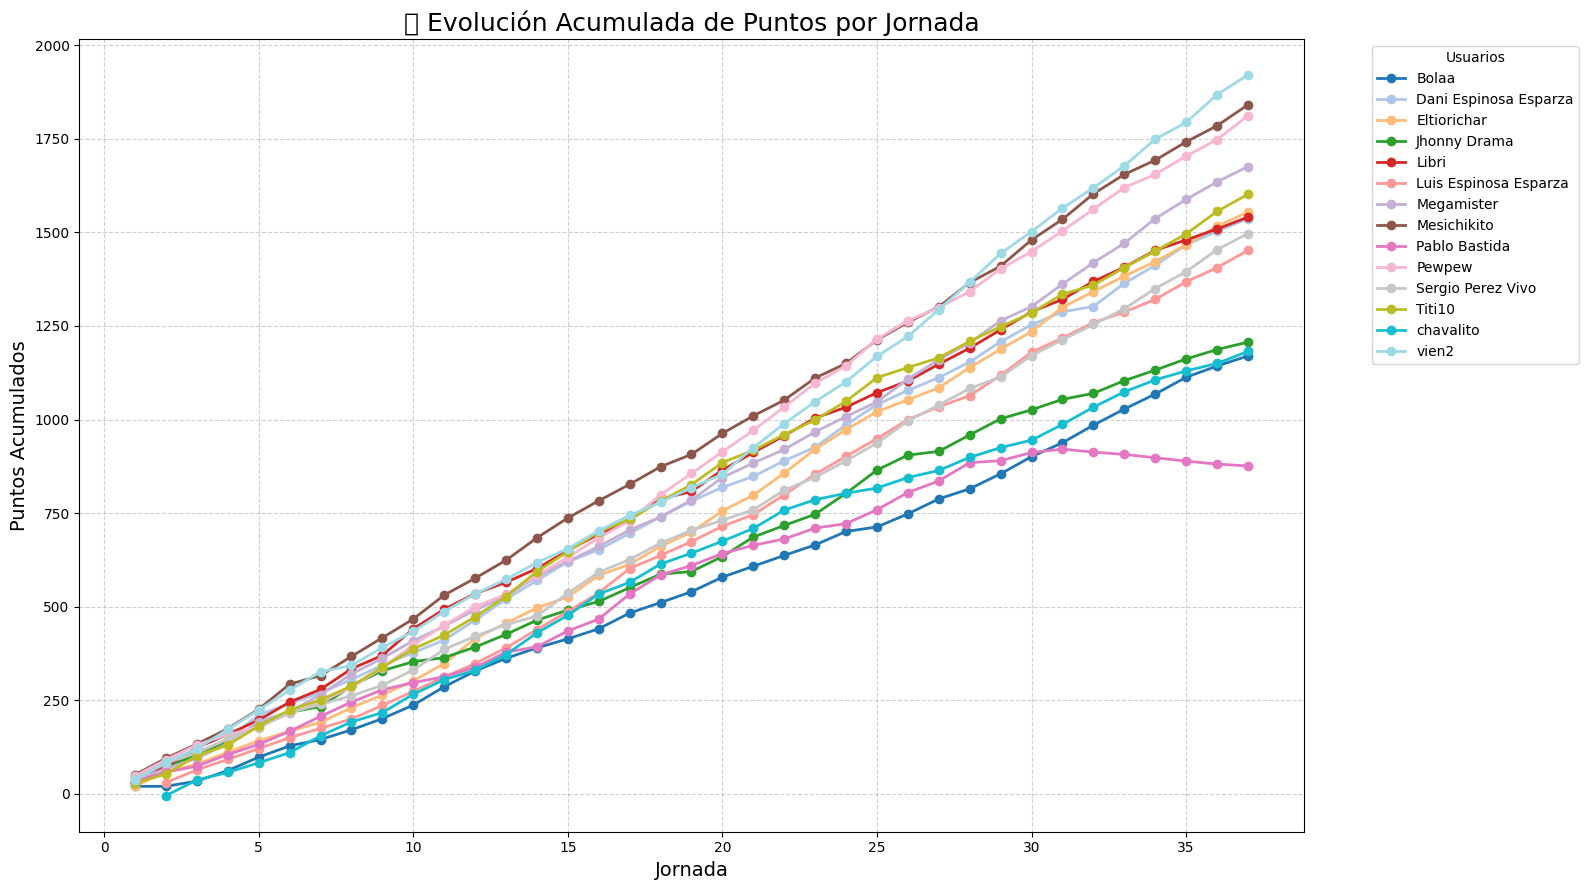

In [62]:
with conexion_db() as conn:
    query = """
        SELECT jornada, usuario, puntos
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
    """
    df = pd.read_sql(query, conn)

# 2. Asegurar tipos correctos
df['jornada'] = df['jornada'].astype(int)
df['puntos'] = df['puntos'].astype(int)

# 3. Ordenar por usuario y jornada
df = df.sort_values(by=['usuario', 'jornada'])

# 4. Calcular puntos acumulados por usuario
df['puntos_acumulados'] = df.groupby('usuario')['puntos'].cumsum()

# 5. Pivot para l√≠neas por usuario
pivot_df = df.pivot(index='jornada', columns='usuario', values='puntos_acumulados')
usuarios = pivot_df.columns
num_usuarios = len(usuarios)

# 6. Crear colores √∫nicos por usuario
colormap = cm.get_cmap('tab20', num_usuarios)
colors = [colormap(i) for i in range(num_usuarios)]

# 7. Graficar
plt.figure(figsize=(16, 9))

for i, usuario in enumerate(usuarios):
    plt.plot(pivot_df.index, pivot_df[usuario], label=usuario, marker='o', linewidth=2, color=colors[i])

plt.title("üìà Evoluci√≥n Acumulada de Puntos por Jornada", fontsize=18)
plt.xlabel("Jornada", fontsize=14)
plt.ylabel("Puntos Acumulados", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Usuarios", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 14. Radar chart ofensivo vs defensivo para un jugador

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1521264371.py:10: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



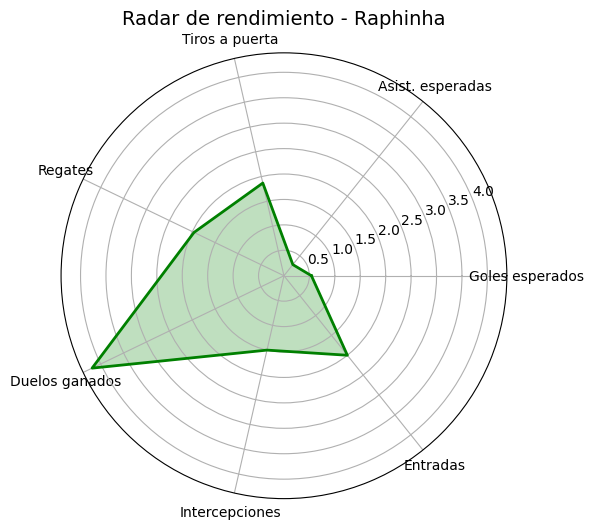

In [63]:
jugador_objetivo = "Raphinha"

with conexion_db() as conn:
    query = f"""
        SELECT *
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25'
          AND (apellido = '{jugador_objetivo}' OR CONCAT(COALESCE(nombre, ''), ' ', COALESCE(apellido, '')) = '{jugador_objetivo}')
    """
    df = pd.read_sql(query, conn)

# Asegurar que hay datos
if df.empty:
    print(f"No se encontraron registros para {jugador_objetivo}")
else:
    # Campos a incluir en el radar
    stats = {
        'Goles esperados': 'goles_esperados',
        'Asist. esperadas': 'asistencias_esperadas',
        'Tiros a puerta': 'tiros_a_puerta',
        'Regates': 'regates_completados',
        'Duelos ganados': 'duelos_ganados',
        'Intercepciones': 'intercepciones',
        'Entradas': 'entradas_totales'
    }

    # Calcular promedio por estad√≠stica
    valores = [df[col].mean() for col in stats.values()]
    labels = list(stats.keys())

    # Preparar radar chart
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    valores += valores[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, valores, color='green', linewidth=2)
    ax.fill(angles, valores, color='green', alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)

    # Construir nombre completo para t√≠tulo
    nombre_titulo = f"{df['nombre'].iloc[0] or ''} {df['apellido'].iloc[0]}".strip()
    ax.set_title(f"Radar de rendimiento - {nombre_titulo}", size=14)

    plt.tight_layout()
    plt.show()

# 15. Ranking de regularidad (mejor media puntuaci√≥n)

In [64]:
with conexion_db() as conn:
    query = """
        SELECT 
            j.id_jugador,
            j.nombre,
            j.apellido,
            g.propietario,
            AVG(j.puntuacion) AS media_puntos,
            COUNT(*) AS partidos
        FROM dbo.v_datos_jornadas j
        JOIN dbo.v_datos_jugador g ON j.id_jugador = g.id_jugador
        WHERE j.temporada = '24/25' AND j.puntuacion IS NOT NULL
        GROUP BY j.id_jugador, j.nombre, j.apellido, g.propietario
        HAVING COUNT(*) >= 5
        ORDER BY media_puntos DESC
        LIMIT 10
    """
    df_regularidad = pd.read_sql(query, conn)

# Construir nombre completo
df_regularidad['jugador'] = (df_regularidad['nombre'].fillna('') + ' ' + df_regularidad['apellido'].fillna('')).str.strip()

# Ordenar columnas
df_regularidad = df_regularidad[['jugador', 'propietario', 'media_puntos', 'partidos']]

# Mostrar bonito
print(df_regularidad.to_string(index=False))


           jugador propietario  media_puntos  partidos
     Kylian Mbapp√©       vien2      8.903226        31
          Raphinha       Bolaa      8.257143        35
      Lamine Yamal Mesichikito      7.882353        34
              Isco      Pewpew      7.714286        21
Robert Lewandowski       Libri      7.531250        32
      Oihan Sancet Mesichikito      7.500000        28
       Ayoze P√©rez       vien2      7.466667        30
             Pedri       Libri      7.444444        36
        Alex Baena  Megamister      7.161290        31
         Dani Olmo Eltiorichar      7.125000        24


C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\2261645813.py:18: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 16. Mejor jornada de cada jugador

In [65]:
with conexion_db() as conn:
    query = """
        SELECT nombre, apellido, jornada, puntuacion
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25'
        and sancionolesion not in ('No jug√≥ la jornada', 'No convocado')
    """
    df = pd.read_sql(query, conn)

df['jugador'] = (df['nombre'].fillna('') + ' ' + df['apellido'].fillna('')).str.strip()
mejor_jornada = df.sort_values(['jugador', 'puntuacion'], ascending=[True, False])
mejor_jornada = mejor_jornada.drop_duplicates('jugador')

print(mejor_jornada[['jugador', 'jornada', 'puntuacion']].sort_values(by='puntuacion', ascending=False).head(10))


                  jugador  jornada  puntuacion
11328   Alexander S√∏rloth       35        25.0
7116         Oihan Sancet       23        23.0
5812          Kike Garc√≠a       20        21.0
2537   Robert Lewandowski        9        21.0
620              Raphinha        4        21.0
5188        Thierno Barry       18        21.0
6438        Kylian Mbapp√©       21        21.0
1321           Javi Puado        5        20.0
3903      Vin√≠cius J√∫nior       13        20.0
6767         Ferm√≠n L√≥pez       21        20.0


C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\723815745.py:8: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 17. Jugador con m√°s apariciones en el once ideal

In [66]:
with conexion_db() as conn:
    query = """
        SELECT id_jugador, nombre, COUNT(*) as veces_en_once
        FROM dbo.v_best_xi_jornadas
        WHERE temporada = '24/25'
        GROUP BY id_jugador, nombre
        ORDER BY veces_en_once DESC
        LIMIT 10
    """
    df_once = pd.read_sql(query, conn)

print(df_once)


   id_jugador              nombre  veces_en_once
0       58954       Kylian Mbappe             10
1       48657            Raphinha              9
2       48684  Robert Lewandowski              9
3       59415           Dani Olmo              7
4       22547               Pedri              7
5       29166         Joan Garcia              7
6       53114     Jude Bellingham              6
7       14789        Oihan Sancet              6
8       18004        Ante Budimir              6
9       59476      Julian Alvarez              6


C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\2492212660.py:10: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 18. Eficiencia goleadora (goles / tiros a puerta)

In [67]:
with conexion_db() as conn:
    query = """
        SELECT id_jugador, nombre, apellido, eventos, tiros_a_puerta
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25' AND tiros_a_puerta IS NOT NULL
    """
    df = pd.read_sql(query, conn)

# Extraer goles desde la columna 'eventos'
df['goles'] = df['eventos'].fillna('').str.count(r'\bgol\b')
df['jugador'] = (df['nombre'].fillna('') + ' ' + df['apellido'].fillna('')).str.strip()

# Agrupar por jugador
agrupado = df.groupby(['id_jugador', 'jugador']).agg({
    'goles': 'sum',
    'tiros_a_puerta': 'sum',
    'eventos': 'count'  # para saber cu√°ntas jornadas tiene
}).reset_index()

# Filtrar con m√≠nimo de tiros a puerta para ser relevante
agrupado = agrupado[agrupado['tiros_a_puerta'] >= 5]

# Calcular eficiencia
agrupado['eficiencia'] = agrupado['goles'] / agrupado['tiros_a_puerta']

# Ordenar
eficientes = agrupado.sort_values(by='eficiencia', ascending=False).head(10)

# Mostrar
print(eficientes[['jugador', 'goles', 'tiros_a_puerta', 'eficiencia']].to_string(index=False))


          jugador  goles  tiros_a_puerta  eficiencia
   Juanlu S√°nchez      4               5    0.800000
    Daniel Vivian      4               5    0.800000
Roberto Fern√°ndez      6               8    0.750000
       Umar Sadiq      5               7    0.714286
       Path√© Ciss      4               6    0.666667
  Leandro Cabrera      4               6    0.666667
      Ayoze P√©rez     19              31    0.612903
   Martin Valjent      3               5    0.600000
   Seydouba Cisse      3               5    0.600000
       √Ålex Mu√±oz      3               5    0.600000


C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1456666644.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 19. Efectividad total de tiro

In [68]:
with conexion_db() as conn:
    query = """
        SELECT id_jugador, nombre, apellido, eventos, tiros_a_puerta, tiros_fuera
        FROM dbo.v_datos_jornadas
        WHERE temporada = '24/25'
          AND (tiros_a_puerta IS NOT NULL OR tiros_fuera IS NOT NULL)
    """
    df = pd.read_sql(query, conn)

# Calcular goles desde eventos
df['goles'] = df['eventos'].fillna('').str.count(r'\bgol\b')
df['jugador'] = (df['nombre'].fillna('') + ' ' + df['apellido'].fillna('')).str.strip()

# Reemplazar NaN por 0 para suma de tiros
df['tiros_a_puerta'] = df['tiros_a_puerta'].fillna(0)
df['tiros_fuera'] = df['tiros_fuera'].fillna(0)

# Agrupar por jugador
agrupado = df.groupby(['id_jugador', 'jugador']).agg({
    'goles': 'sum',
    'tiros_a_puerta': 'sum',
    'tiros_fuera': 'sum'
}).reset_index()

# Calcular total de tiros y eficiencia
agrupado['tiros_totales'] = agrupado['tiros_a_puerta'] + agrupado['tiros_fuera']
agrupado = agrupado[agrupado['tiros_totales'] >= 5]  # m√≠nimo de tiros para ser relevante
agrupado['efectividad_total'] = agrupado['goles'] / agrupado['tiros_totales']

# Ordenar
ranking = agrupado.sort_values(by='efectividad_total', ascending=False).head(10)

# Mostrar
print(ranking[['jugador', 'goles', 'tiros_totales', 'efectividad_total']].to_string(index=False))


          jugador  goles  tiros_totales  efectividad_total
    Aitor Paredes      3            5.0           0.600000
      Pablo Torre      3            6.0           0.500000
Roberto Fern√°ndez      6           13.0           0.461538
   Juanlu S√°nchez      4           10.0           0.400000
       √Ålex Mu√±oz      3            8.0           0.375000
     Rub√©n Garc√≠a      5           14.0           0.357143
   Martin Valjent      3            9.0           0.333333
       Pere Milla      2            6.0           0.333333
      Ayoze P√©rez     19           57.0           0.333333
 Javier Rodr√≠guez      3            9.0           0.333333

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\2852531100.py:8: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 20. Evoluci√≥n valor equipo

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1507975526.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1507975526.py:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1507975526.py:33: UserWarning:

Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.

C:\Users\juan_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.



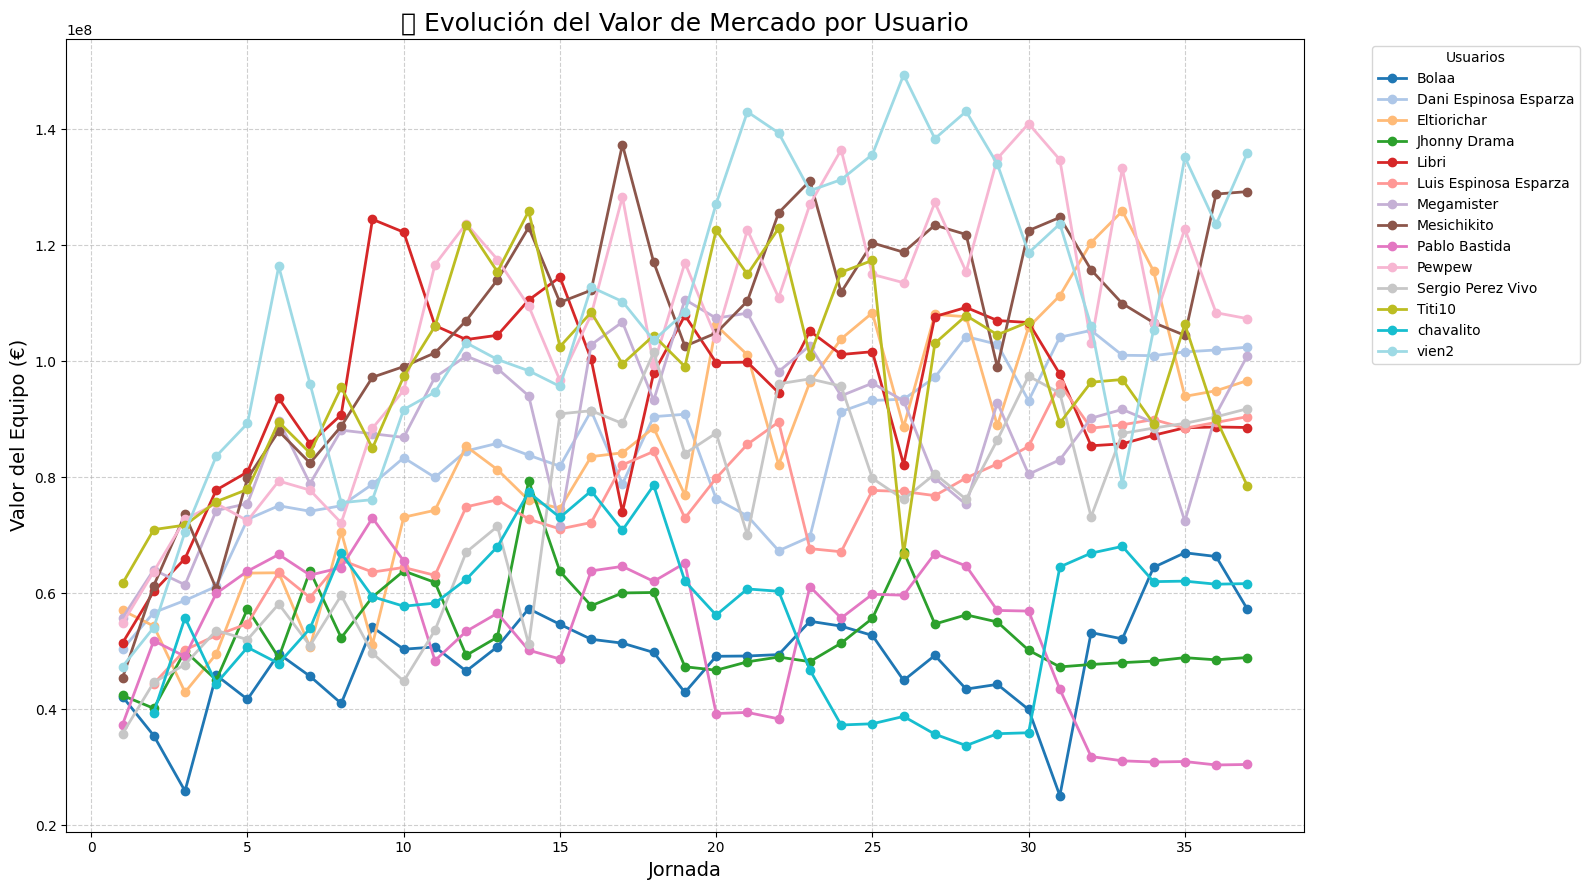

In [69]:
with conexion_db() as conn:
    query = """
        SELECT jornada, usuario, valor_equipo
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
    """
    df = pd.read_sql(query, conn)

# 2. Convertir tipos
df['jornada'] = df['jornada'].astype(int)
df['valor_equipo'] = df['valor_equipo'].astype(float)

# 3. Pivot para l√≠neas por usuario
pivot_df = df.pivot(index='jornada', columns='usuario', values='valor_equipo')
usuarios = pivot_df.columns
num_usuarios = len(usuarios)

# 4. Colores √∫nicos por usuario
colormap = cm.get_cmap('tab20', num_usuarios)
colors = [colormap(i) for i in range(num_usuarios)]

# 5. Graficar
plt.figure(figsize=(16, 9))

for i, usuario in enumerate(usuarios):
    plt.plot(pivot_df.index, pivot_df[usuario], label=usuario, marker='o', linewidth=2, color=colors[i])

plt.title("üí∏ Evoluci√≥n del Valor de Mercado por Usuario", fontsize=18)
plt.xlabel("Jornada", fontsize=14)
plt.ylabel("Valor del Equipo (‚Ç¨)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Usuarios", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 21. ¬øQui√©n ha terminado m√°s veces primero?

In [70]:
with conexion_db() as conn:
    query = """
        SELECT usuario, COUNT(*) AS veces_primero
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25' AND posicion = 1
        GROUP BY usuario
        ORDER BY veces_primero DESC
    """
    df = pd.read_sql(query, conn)

print(df.to_string(index=False))


              usuario  veces_primero
                vien2             10
Dani Espinosa Esparza              5
          Mesichikito              5
               Pewpew              5
          Eltiorichar              4
                Libri              3
           Megamister              2
               Titi10              1
        Pablo Bastida              1
    Sergio Perez Vivo              1


C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\2587310815.py:9: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 22. Mayor media de puntos por jornada

In [71]:
with conexion_db() as conn:
    query = """
        SELECT usuario, AVG(puntos) AS media_puntos, COUNT(*) AS jornadas
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
        GROUP BY usuario
        HAVING COUNT(*) >= 5
        ORDER BY media_puntos DESC
    """
    df = pd.read_sql(query, conn)

print(df.to_string(index=False))


              usuario  media_puntos  jornadas
                vien2     51.918919        37
          Mesichikito     49.756757        37
               Pewpew     48.972973        37
           Megamister     45.297297        37
               Titi10     43.297297        37
          Eltiorichar     42.000000        37
                Libri     41.648649        37
Dani Espinosa Esparza     41.540541        37
    Sergio Perez Vivo     40.459459        37
Luis Espinosa Esparza     40.333333        36
            chavalito     32.833333        36
         Jhonny Drama     32.621622        37
                Bolaa     31.621622        37
        Pablo Bastida     23.675676        37


C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\2891315632.py:10: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 23. Mejor jornada

In [72]:
with conexion_db() as conn:
    query = """
        SELECT usuario, jornada, puntos
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
        ORDER BY puntos DESC
        LIMIT 1
    """
    df = pd.read_sql(query, conn)

print(df.to_string(index=False))


usuario  jornada  puntos
  vien2       29      77


C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\2668635103.py:9: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 24. Peor jornada

In [73]:
with conexion_db() as conn:
    query = """
        SELECT usuario, jornada, puntos
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
        ORDER BY puntos asc
        LIMIT 1
    """
    df = pd.read_sql(query, conn)

print(df.to_string(index=False))


C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\3951790482.py:9: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



      usuario  jornada  puntos
Pablo Bastida       34      -9


# 25. Relaci√≥n entre puntos y valor del equipo

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\3652622789.py:7: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



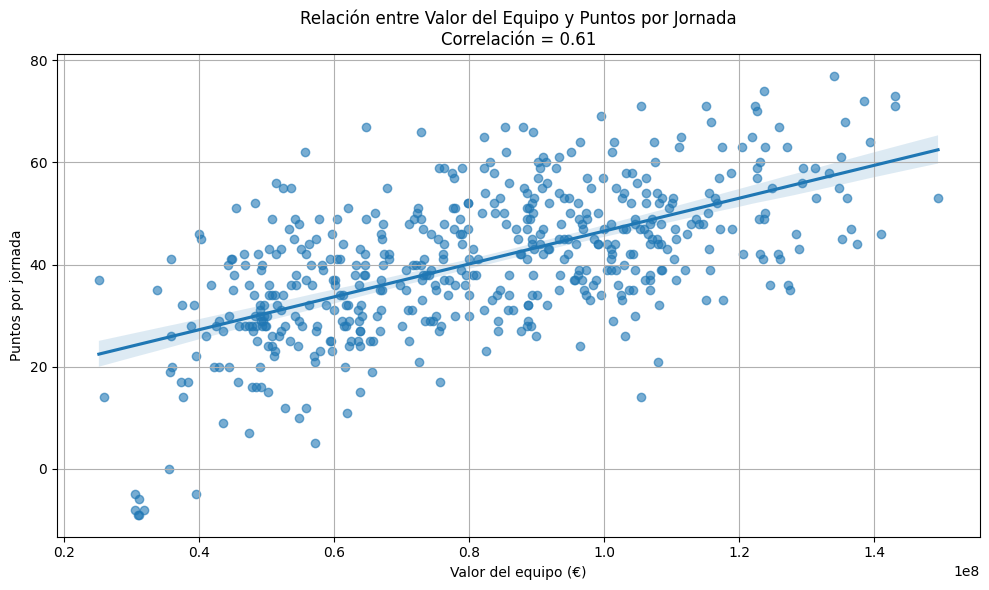

In [74]:
with conexion_db() as conn:
    query = """
        SELECT usuario, puntos, valor_equipo
        FROM dbo.v_clasificacion_jornada
        WHERE temporada = '24/25'
    """
    df = pd.read_sql(query, conn)

# Asegurar tipos correctos
df['valor_equipo'] = df['valor_equipo'].astype(float)

# Calcular correlaci√≥n
correlacion = df['puntos'].corr(df['valor_equipo'])

# Scatter plot
plt.figure(figsize=(10, 6))
sns.regplot(data=df, x="valor_equipo", y="puntos", scatter_kws={'alpha': 0.6})
plt.title(f"Relaci√≥n entre Valor del Equipo y Puntos por Jornada\nCorrelaci√≥n = {correlacion:.2f}")
plt.xlabel("Valor del equipo (‚Ç¨)")
plt.ylabel("Puntos por jornada")
plt.grid(True)
plt.tight_layout()
plt.show()

# 26. Usuarios con m√°s ganancias y p√©rdidas en cl√°usulas

In [75]:
def formatear_millones(valor):
    return f"{valor / 1_000_000:,.1f} M‚Ç¨".replace(",", ".")

with conexion_db() as conn:
    query = """
        SELECT tipo_operacion, usuario_origen, usuario_destino, precio
        FROM dbo.v_transferencias
        WHERE tipo_operacion = 'Cl√°usula'
          AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30'
    """
    df = pd.read_sql(query, conn)

# Sumar lo ganado y perdido por usuario
ganado = df.groupby('usuario_origen')['precio'].sum().reset_index(name='ganado')
perdido = df.groupby('usuario_destino')['precio'].sum().reset_index(name='perdido')

# Unir por usuario
balance = pd.merge(ganado, perdido, left_on='usuario_origen', right_on='usuario_destino', how='outer')
balance['usuario'] = balance['usuario_origen'].combine_first(balance['usuario_destino'])
balance = balance.fillna(0)

# Calcular balance neto
balance['balance_clausulas'] = balance['ganado'] - balance['perdido']

# Seleccionar columnas y ordenar
balance_final = balance[['usuario', 'ganado', 'perdido', 'balance_clausulas']].sort_values(by='balance_clausulas', ascending=False)

# Formatear columnas en millones
for col in ['ganado', 'perdido', 'balance_clausulas']:
    balance_final[col] = balance_final[col].apply(formatear_millones)

# Mostrar resultados
print("üü¢ Usuarios que m√°s ganaron en cl√°usulas:\n")
print(balance_final.head(5).to_string(index=False))

print("\nüî¥ Usuarios que m√°s perdieron en cl√°usulas:\n")
print(balance_final.tail(5).sort_values(by='balance_clausulas').to_string(index=False))

üü¢ Usuarios que m√°s ganaron en cl√°usulas:

      usuario   ganado  perdido balance_clausulas
       Pewpew 613.7 M‚Ç¨ 407.3 M‚Ç¨          206.4 M‚Ç¨
        vien2 679.0 M‚Ç¨ 559.7 M‚Ç¨          119.3 M‚Ç¨
Pablo Bastida 212.1 M‚Ç¨ 147.4 M‚Ç¨           64.7 M‚Ç¨
       Titi10 618.6 M‚Ç¨ 585.6 M‚Ç¨           33.0 M‚Ç¨
  Eltiorichar 594.6 M‚Ç¨ 562.8 M‚Ç¨           31.8 M‚Ç¨

üî¥ Usuarios que m√°s perdieron en cl√°usulas:

              usuario   ganado  perdido balance_clausulas
Dani Espinosa Esparza 309.9 M‚Ç¨ 415.4 M‚Ç¨         -105.5 M‚Ç¨
           Megamister 554.3 M‚Ç¨ 669.9 M‚Ç¨         -115.6 M‚Ç¨
         Jhonny Drama 197.0 M‚Ç¨ 358.1 M‚Ç¨         -161.1 M‚Ç¨
Luis Espinosa Esparza 443.3 M‚Ç¨ 472.5 M‚Ç¨          -29.2 M‚Ç¨
    Sergio Perez Vivo 561.3 M‚Ç¨ 604.5 M‚Ç¨          -43.2 M‚Ç¨


C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\83764041.py:11: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



# 27. Mejor 11

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\2037078629.py:8: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\juan_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 9917 (\N{SOCCER BALL}) missing from current font.



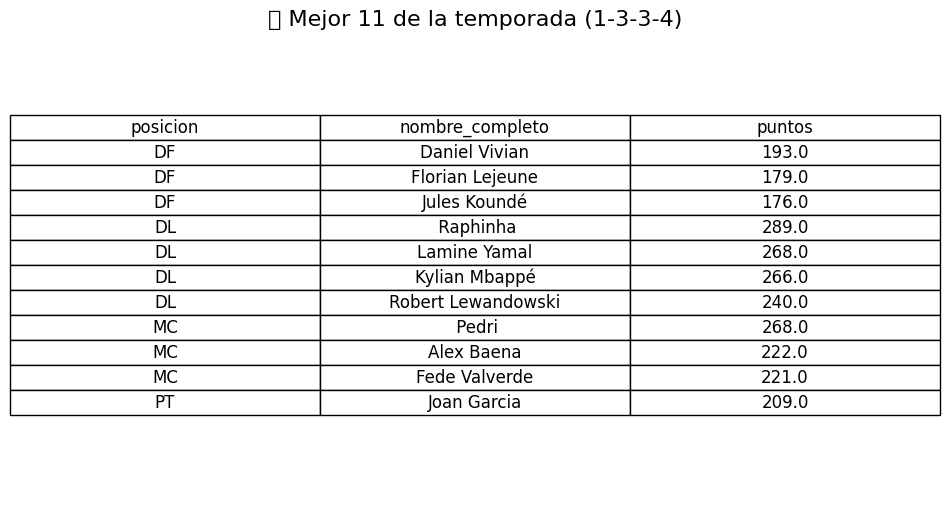

posicion    nombre_completo  puntos
      DF      Daniel Vivian   193.0
      DF    Florian Lejeune   179.0
      DF       Jules Kound√©   176.0
      DL           Raphinha   289.0
      DL       Lamine Yamal   268.0
      DL      Kylian Mbapp√©   266.0
      DL Robert Lewandowski   240.0
      MC              Pedri   268.0
      MC         Alex Baena   222.0
      MC      Fede Valverde   221.0
      PT        Joan Garcia   209.0


In [83]:
with conexion_db() as conn:
    query = """
        SELECT id_jugador, nombre, apellido, posicion, puntos
        FROM dbo.v_datos_jugador
        WHERE puntos IS NOT NULL AND puntos > 0
        and temporada = '24/25'
    """
    df = pd.read_sql(query, conn)

# 2. Asegurar tipos
df['puntos'] = df['puntos'].astype(float)
df['posicion'] = df['posicion'].str.upper().str.strip()

# 3. Mapeo de posiciones v√°lidas
alineacion_deseada = {
    'PT': 1,
    'DF': 3,
    'MC': 3,
    'DL': 4
}

# 4. Seleccionar los mejores jugadores por posici√≥n
mejor_once = []

for pos, cantidad in alineacion_deseada.items():
    jugadores_pos = df[df['posicion'] == pos].sort_values(by='puntos', ascending=False).head(cantidad)
    mejor_once.append(jugadores_pos)

# 5. Concatenar todos
mejor_once_df = pd.concat(mejor_once).reset_index(drop=True)

# 6. Formatear y mostrar resultados
mejor_once_df['nombre_completo'] = mejor_once_df['nombre'].fillna('') + ' ' + mejor_once_df['apellido'].fillna('')
mejor_once_df = mejor_once_df[['posicion', 'nombre_completo', 'puntos']].sort_values(by='posicion')

# Mostrar como tabla bonita
import matplotlib.pyplot as plt
import matplotlib.table as tbl

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')
table = tbl.table(
    ax,
    cellText=mejor_once_df.values,
    colLabels=mejor_once_df.columns,
    loc='center',
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title("‚öΩ Mejor 11 de la temporada (1-3-3-4)", fontsize=16)
plt.show()

# Tambi√©n puedes imprimirlo por consola si no usas notebook
print(mejor_once_df.to_string(index=False))

# 28. Balance de cada persona

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1679370674.py:8: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.

C:\Users\juan_\AppData\Local\Temp\ipykernel_25636\1679370674.py:47: UserWarning:

Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.

C:\Users\juan_\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.



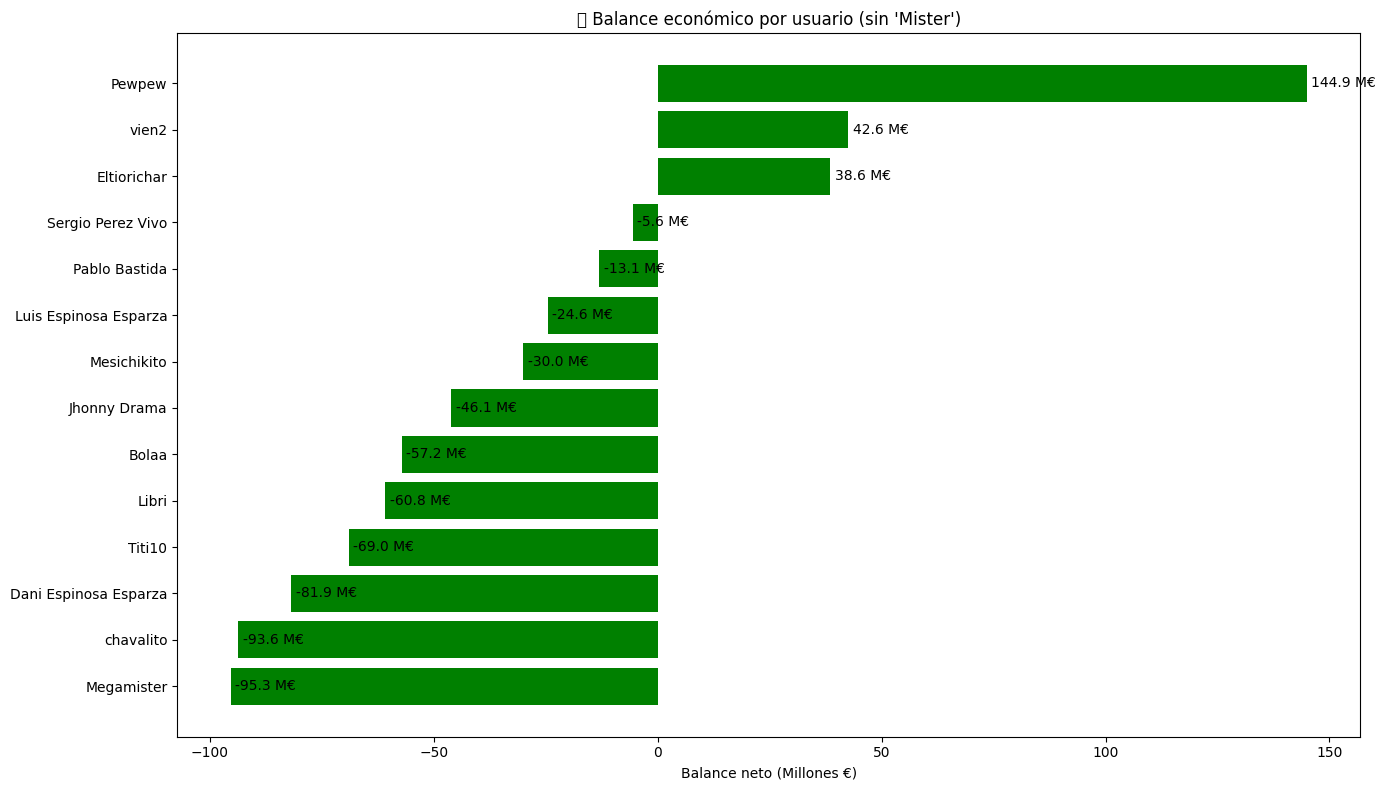

              usuario       ganado      gastado     balance
               Pewpew 1253329519.0 1108407627.0 144921892.0
                vien2 1241759658.0 1199200567.0  42559091.0
          Eltiorichar  840964644.0  802400625.0  38564019.0
    Sergio Perez Vivo  614326124.0  619948804.0  -5622680.0
        Pablo Bastida  231222038.0  244298813.0 -13076775.0
Luis Espinosa Esparza  607858187.0  632468472.0 -24610285.0
          Mesichikito  712262225.0  742280491.0 -30018266.0
         Jhonny Drama  400927940.0  447003069.0 -46075129.0
                Bolaa  241698584.0  298879213.0 -57180629.0
                Libri  624387331.0  685200069.0 -60812738.0
               Titi10  865328089.0  934348187.0 -69020098.0
Dani Espinosa Esparza  455034837.0  536906767.0 -81871930.0
            chavalito  201138705.0  294780089.0 -93641384.0
           Megamister  688028324.0  783319654.0 -95291330.0


In [85]:
with conexion_db() as conn:
    query = """
        SELECT usuario_origen, usuario_destino, precio, tipo_operacion
        FROM dbo.v_transferencias
        WHERE precio IS NOT NULL
        AND fecha_transferencia BETWEEN '2024-08-15' AND '2025-06-30' 
    """
    df = pd.read_sql(query, conn)

# 2. Limpiar y convertir precios (eliminar puntos de separador de miles)
df['precio'] = df['precio'].astype(str).str.replace('.', '', regex=False).astype(float)

# 3. Filtrar transferencias entre usuarios v√°lidos
df = df[(df['usuario_origen'].notnull()) & (df['usuario_destino'].notnull())]

# 4. Calcular dinero ganado por cada usuario (como origen)
df_ganado = df.groupby('usuario_origen')['precio'].sum().reset_index()
df_ganado.columns = ['usuario', 'ganado']

# 5. Calcular dinero gastado por cada usuario (como destino)
df_gastado = df.groupby('usuario_destino')['precio'].sum().reset_index()
df_gastado.columns = ['usuario', 'gastado']

# 6. Unir ambos
balance = pd.merge(df_ganado, df_gastado, on='usuario', how='outer').fillna(0)
balance['balance'] = balance['ganado'] - balance['gastado']

# 7. Eliminar "Mister"
balance = balance[balance['usuario'] != 'Mister']

# 8. Ordenar por balance
balance_sorted = balance.sort_values(by='balance', ascending=False)

# 9. Graficar todos los usuarios
plt.figure(figsize=(14, 8))
bars = plt.barh(balance_sorted['usuario'], balance_sorted['balance'] / 1_000_000, color='green')

# 10. A√±adir etiquetas de valor a cada barra
for i, bar in enumerate(bars):
    valor = balance_sorted.iloc[i]['balance'] / 1_000_000
    plt.text(valor + 1, bar.get_y() + bar.get_height()/2,
             f"{valor:.1f} M‚Ç¨", va='center', fontsize=10)

plt.xlabel("Balance neto (Millones ‚Ç¨)")
plt.title("üü¢ Balance econ√≥mico por usuario (sin 'Mister')")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 11. Mostrar tabla por consola
print(balance_sorted.to_string(index=False))

In [76]:
conn.close()